# Polarization Analysis
author: Louis Richard\
Perform polarization analysis on burst mode electric and magnetic fields. Plots spectrograms, ellipticity, wave-normal angle, planarity, degree of polarization (DOP), phase speed, and normalized Poynting flux along B. Time selections should not be too long (less than 20 seconds), otherwise the analysis will be very slow. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy import constants
from pyrfu import mms, pyrf
from pyrfu.plot import plot_line, plot_spectr

Load IGRF coefficients ...


## Define time interval and spacecraft index

In [2]:
# mms.db_init("/Volumes/mms")
tint = ["2015-10-30T05:15:42.000", "2015-10-30T05:15:54.00"]
tint_long = pyrf.extend_tint(tint, [-100, 100])
ic = 3

## Load data from SDC

In [3]:
r_xyz = mms.get_data("r_gse_mec_srvy_l2", tint_long, ic, from_sdc=True)
b_xyz = mms.get_data("b_gse_fgm_brst_l2", tint, ic, from_sdc=True)
e_xyz = mms.get_data("e_gse_edp_brst_l2", tint, ic, from_sdc=True)
b_scm = mms.get_data("b_gse_scm_brst_l2", tint, ic, from_sdc=True)

[01-Dec-23 00:07:42] INFO: Loading mms3_mec_r_gse...
[01-Dec-23 00:07:49] INFO: Loading mms3_fgm_b_gse_brst_l2...
[01-Dec-23 00:07:55] INFO: Loading mms3_edp_dce_gse_brst_l2...
[01-Dec-23 00:09:08] INFO: Loading mms3_scm_acb_gse_scb_brst_l2...


## Compute electron cylotron frequency

In [4]:
b_si = pyrf.norm(b_xyz) * 1e-9
w_ce = constants.elementary_charge * b_si / constants.electron_mass
f_ce = w_ce / (2 * np.pi)
f_ce_01 = f_ce * 0.1
f_ce_05 = f_ce * 0.5

## Polarization Analysis

In [5]:
polarization_options = dict(freq_int=[10, 4000], polarization=True, fac=True)
polarization = pyrf.ebsp(e_xyz, b_scm, b_xyz, b_xyz, r_xyz, **polarization_options)

[01-Dec-23 00:09:17] INFO: Interpolating b and e to 2x e sampling
[01-Dec-23 00:09:18] INFO: ebsp ... calculate E and B wavelet transform ... 
[01-Dec-23 00:09:29] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/pyrf/ebsp.py:803: RuntimeWarning: invalid value encountered in divide
  np.trace(np.matmul(s_mat_avg, s_mat_avg), axis1=1, axis2=2)

[01-Dec-23 00:09:29] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/pyrf/ebsp.py:824: RuntimeWarning: invalid value encountered in divide
  np.trace(np.matmul(s_mat_avg, s_mat_avg), axis1=1, axis2=2)



### Unpack polarization analysis

In [6]:
frequency = polarization["f"]
time = polarization["t"]
b_sum = polarization["bb_xxyyzzss"][..., 3]
b_per = polarization["bb_xxyyzzss"][..., 0] + polarization["bb_xxyyzzss"][..., 1]
e_sum = polarization["ee_xxyyzzss"][..., 3]
e_per = polarization["ee_xxyyzzss"][..., 0] + polarization["ee_xxyyzzss"][..., 1]
ellipticity = polarization["ellipticity"]
dop = polarization["dop"]
thetak = polarization["k_tp"][..., 0]
planarity = polarization["planarity"]
pflux_z = polarization["pf_xyz"][..., 2]
pflux_z /= np.sqrt(
    polarization["pf_xyz"][..., 0] ** 2
    + polarization["pf_xyz"][..., 1] ** 2
    + polarization["pf_xyz"][..., 2] ** 2
)

### Calculate phase speed v_ph = E/B.

In [7]:
v_ph = np.sqrt(e_sum / b_sum) * 1e6
v_ph_perp = np.sqrt(e_per / b_per) * 1e6

### Remove points with very low B amplitutes

In [8]:
b_sum_thres = 1e-7

ellipticity.data[b_sum < b_sum_thres] = np.nan
thetak.data[b_sum < b_sum_thres] = np.nan
dop.data[b_sum < b_sum_thres] = np.nan
planarity.data[b_sum < b_sum_thres] = np.nan
pflux_z.data[b_sum < b_sum_thres] = np.nan
v_ph.data[b_sum < b_sum_thres] = np.nan
v_ph_perp.data[b_sum < b_sum_thres] = np.nan

## Plot figure

Text(0, 0.5, '$S_{||}/|S|$\n ')

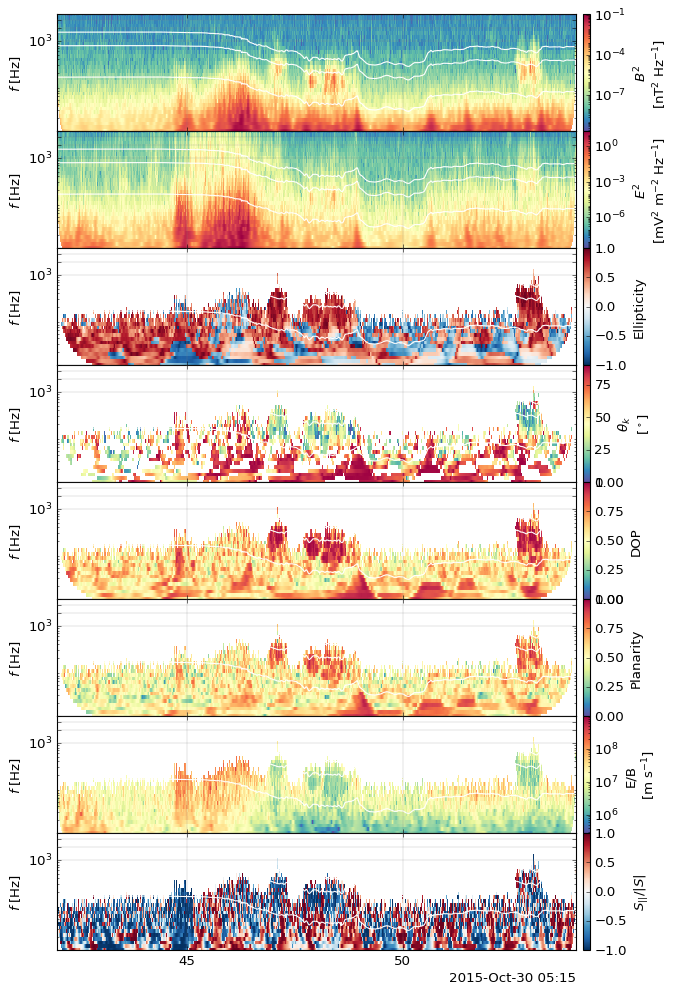

In [9]:
f, axs = plt.subplots(8, sharex="all", figsize=(9, 13))
f.subplots_adjust(hspace=0, left=0.1, right=0.82, bottom=0.05, top=0.95)
axs[0], caxs0 = plot_spectr(
    axs[0], b_sum, yscale="log", cscale="log", cmap="Spectral_r"
)
plot_line(axs[0], f_ce, color="w")
plot_line(axs[0], f_ce_01, color="w")
plot_line(axs[0], f_ce_05, color="w")
axs[0].set_ylabel("$f$ [Hz]")
caxs0.set_ylabel("$B^2$" + "\n" + "[nT$^2$ Hz$^{-1}$]")

axs[1], caxs1 = plot_spectr(
    axs[1], e_sum, yscale="log", cscale="log", cmap="Spectral_r"
)
plot_line(axs[1], f_ce, color="w")
plot_line(axs[1], f_ce_01, color="w")
plot_line(axs[1], f_ce_05, color="w")
axs[1].set_ylabel("$f$ [Hz]")
caxs1.set_ylabel("$E^2$" + "\n" + "[mV$^2$ m$^{-2}$ Hz$^{-1}$]")

axs[2], caxs2 = plot_spectr(
    axs[2], ellipticity, yscale="log", cmap="RdBu_r", clim=[-1, 1]
)
plot_line(axs[2], f_ce, color="w")
plot_line(axs[2], f_ce_01, color="w")
plot_line(axs[2], f_ce_05, color="w")
axs[2].set_ylabel("$f$ [Hz]")
caxs2.set_ylabel("Ellipticity" + "\n" + " ")

axs[3], caxs3 = plot_spectr(
    axs[3], thetak * 180 / np.pi, yscale="log", cmap="Spectral_r", clim=[0, 90]
)
plot_line(axs[3], f_ce, color="w")
plot_line(axs[3], f_ce_01, color="w")
plot_line(axs[3], f_ce_05, color="w")
axs[3].set_ylabel("$f$ [Hz]")
caxs3.set_ylabel("$\\theta_k$" + "\n" + "[$^\\circ$]")

axs[4], caxs4 = plot_spectr(axs[4], dop, yscale="log", cmap="Spectral_r", clim=[0, 1])
plot_line(axs[4], f_ce, color="w")
plot_line(axs[4], f_ce_01, color="w")
plot_line(axs[4], f_ce_05, color="w")
axs[4].set_ylabel("$f$ [Hz]")
caxs4.set_ylabel("DOP" + "\n" + " ")


axs[5], caxs5 = plot_spectr(
    axs[5], planarity, yscale="log", cmap="Spectral_r", clim=[0, 1]
)
plot_line(axs[5], f_ce, color="w")
plot_line(axs[5], f_ce_01, color="w")
plot_line(axs[5], f_ce_05, color="w")
axs[5].set_ylabel("$f$ [Hz]")
caxs5.set_ylabel("Planarity" + "\n" + " ")


axs[6], caxs6 = plot_spectr(axs[6], v_ph, yscale="log", cscale="log", cmap="Spectral_r")
plot_line(axs[6], f_ce, color="w")
plot_line(axs[6], f_ce_01, color="w")
plot_line(axs[6], f_ce_05, color="w")
axs[6].set_ylabel("$f$ [Hz]")
caxs6.set_ylabel("E/B" + "\n" + "[m s$^{-1}$]")

axs[7], caxs7 = plot_spectr(axs[7], pflux_z, yscale="log", cmap="RdBu_r", clim=[-1, 1])
plot_line(axs[7], f_ce, color="w")
plot_line(axs[7], f_ce_01, color="w")
plot_line(axs[7], f_ce_05, color="w")
axs[7].set_ylabel("$f$ [Hz]")
caxs7.set_ylabel("$S_{||}/|S|$" + "\n" + " ")